# Assay Selection

In this notebook, we prepare data for our new future directions:

- Use median image CellProfiler features as a baseline model
- Good models only need to perform well on certain assays
- Compound diversity is important across training and testing

## 1. Median Feature Extraction

In this section, we can aggregate cell level features to image level by computing the median.

In [58]:
import sqlite3
import pandas as pd
import numpy as np
from json import load, dump

In [59]:
# Load the mean table so we know the pid, wid, sid
df = pd.read_csv('./data/test/meta_data/extracted_features/mean_well_profiles.csv')
df.head()

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_ASSAY_WELL_ROLE,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,26795,a01,26795,H-CBLD-004-4,a01,treated,BRD-K08867654-001-01-6,4.961919,DMSO,BRD-K08867654,...,3.200403,1.953486,1.941743,1.970486,1.664505,1.584247,1.586885,1.963939,2.063034,2.120759
1,26795,a02,26795,H-CBLD-004-4,a02,treated,BRD-K26581628-001-01-4,4.921157,DMSO,BRD-K26581628,...,3.456203,1.867099,1.854707,1.846309,1.427015,1.423535,1.420690,2.074904,2.070163,2.115892
2,26795,a03,26795,H-CBLD-004-4,a03,treated,BRD-K55775078-001-01-1,4.806274,DMSO,BRD-K55775078,...,3.502307,1.786906,1.875530,1.890009,1.394290,1.462195,1.436593,2.163032,2.173836,2.232259
3,26795,a04,26795,H-CBLD-004-4,a04,treated,BRD-K75499899-001-01-1,4.907432,DMSO,BRD-K75499899,...,3.923080,2.059223,2.140274,2.145159,1.670193,1.745242,1.724127,2.355939,2.302446,2.341100
4,26795,a05,26795,H-CBLD-004-4,a05,treated,BRD-K14998923-001-01-6,5.029488,DMSO,BRD-K14998923,...,3.506867,1.866429,1.815833,1.827246,1.457231,1.474503,1.454954,2.159988,2.165450,2.231840


In [60]:
conn = sqlite3.connect('./data/test/meta_data/extracted_features/26795.sqlite')
c = conn.cursor()

In [9]:
#cur = c.execute("SELECT * FROM Image")
#[tuple[0] for tuple in cur.description]

**Step 1:** Extract `TableNumber` while dynamically considering the sites (field of views).

In [61]:
pid = 26795
wid = 'a01'

In [62]:
# Extract all cell features using given 
c.execute(
    """
    SELECT TableNumber, ImageNumber, Image_Count_Cells
    FROM Image
    WHERE Image_Metadata_Plate = {} AND Image_Metadata_Well = '{}'
    """.format(pid, wid)
)

result = c.fetchall()
print(result)

[(u'913e6d24750b2b8e9c32ac47e4cbfdde', 1, 60.0), (u'f821fbb017abc16057c50279848bdde4', 2, 33.0), (u'94424bd0f2483095a2d49b5ca510b1c1', 3, 48.0), (u'b2cd3be4aa5712affc6d074b0eed4303', 4, 80.0), (u'9bfd4e6d3eb75696d419070645ebbe89', 5, 65.0), (u'cdf2f514e10b8cb8d64b24b128b54c78', 6, 52.0)]


**Step 2:** Extract features from the Image table (no median here)

In [63]:
image_feature_filter_name = [
    'TableNumber', 'ImageNumber', 'ObjectNumber',
    'Image_Group_Index', 'Image_Group_Number', 'Image_Metadata_Plate',
    'Image_Metadata_Site', 'Image_Metadata_Well',
    'Image_FileName_CellOutlines', 'Image_FileName_IllumAGP',
    'Image_FileName_IllumDNA', 'Image_FileName_IllumER',
    'Image_FileName_IllumMito', 'Image_FileName_IllumRNA',
    'Image_FileName_NucleiOutlines', 'Image_FileName_OrigAGP',
    'Image_FileName_OrigDNA', 'Image_FileName_OrigER',
    'Image_FileName_OrigMito', 'Image_FileName_OrigRNA',
    'Nuclei_AreaShape_Zernike_2_2',
    'Nuclei_AreaShape_Zernike_3_1',
    'Nuclei_AreaShape_Zernike_3_3',
    'Nuclei_AreaShape_Zernike_4_0',
    'Nuclei_AreaShape_Zernike_4_2',
    'Nuclei_AreaShape_Zernike_4_4',
    'Nuclei_AreaShape_Zernike_5_1', 
    'Nuclei_AreaShape_Zernike_5_3',
    'Nuclei_AreaShape_Zernike_5_5',
    'Nuclei_AreaShape_Zernike_6_0',
    'Nuclei_AreaShape_Zernike_6_2',
    'Nuclei_AreaShape_Zernike_6_4',
    'Nuclei_RadialDistribution_FracAtD_AGP_1of4',
    'Nuclei_RadialDistribution_FracAtD_AGP_2of4',
    'Nuclei_RadialDistribution_FracAtD_AGP_3of4',
    'Nuclei_RadialDistribution_FracAtD_AGP_4of4',
    'Nuclei_RadialDistribution_FracAtD_DNA_1of4',
    'Nuclei_RadialDistribution_FracAtD_DNA_2of4',
    'Nuclei_RadialDistribution_FracAtD_DNA_3of4',
    'Nuclei_RadialDistribution_FracAtD_DNA_4of4',
    'Nuclei_RadialDistribution_FracAtD_ER_1of4',
    'Nuclei_RadialDistribution_FracAtD_ER_2of4',
    'Nuclei_RadialDistribution_FracAtD_ER_3of4',
    'Nuclei_RadialDistribution_FracAtD_ER_4of4',
    'Nuclei_RadialDistribution_FracAtD_Mito_1of4',
    'Nuclei_RadialDistribution_FracAtD_Mito_2of4',
    'Nuclei_RadialDistribution_FracAtD_Mito_3of4',
    'Nuclei_RadialDistribution_FracAtD_Mito_4of4',
    'Nuclei_RadialDistribution_FracAtD_RNA_1of4',
    'Nuclei_RadialDistribution_FracAtD_RNA_2of4',
    'Nuclei_RadialDistribution_FracAtD_RNA_3of4',
    'Nuclei_RadialDistribution_FracAtD_RNA_4of4',
    'Nuclei_RadialDistribution_MeanFrac_AGP_1of4',
    'Nuclei_RadialDistribution_MeanFrac_AGP_2of4',
    'Nuclei_RadialDistribution_MeanFrac_AGP_3of4',
    'Nuclei_RadialDistribution_MeanFrac_AGP_4of4',
    'Nuclei_RadialDistribution_MeanFrac_DNA_1of4',
    'Nuclei_RadialDistribution_MeanFrac_DNA_2of4',
    'Nuclei_RadialDistribution_MeanFrac_DNA_3of4',
    'Nuclei_RadialDistribution_MeanFrac_DNA_4of4',
    'Nuclei_RadialDistribution_MeanFrac_ER_1of4',
    'Nuclei_RadialDistribution_MeanFrac_ER_2of4',
    'Nuclei_RadialDistribution_MeanFrac_ER_3of4',
    'Nuclei_RadialDistribution_MeanFrac_ER_4of4',
    'Nuclei_RadialDistribution_MeanFrac_Mito_1of4',
    'Nuclei_RadialDistribution_MeanFrac_Mito_2of4',
    'Nuclei_RadialDistribution_MeanFrac_Mito_3of4',
    'Nuclei_RadialDistribution_MeanFrac_Mito_4of4',
    'Nuclei_RadialDistribution_MeanFrac_RNA_1of4',
    'Nuclei_RadialDistribution_MeanFrac_RNA_2of4',
    'Nuclei_RadialDistribution_MeanFrac_RNA_3of4',
    'Nuclei_RadialDistribution_MeanFrac_RNA_4of4',
    'Nuclei_RadialDistribution_RadialCV_AGP_1of4',
    'Nuclei_RadialDistribution_RadialCV_AGP_2of4',
    'Nuclei_RadialDistribution_RadialCV_AGP_3of4',
    'Nuclei_RadialDistribution_RadialCV_AGP_4of4',
    'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
    'Nuclei_RadialDistribution_RadialCV_DNA_2of4',
    'Nuclei_RadialDistribution_RadialCV_DNA_3of4',
    'Nuclei_RadialDistribution_RadialCV_DNA_4of4',
    'Nuclei_RadialDistribution_RadialCV_ER_1of4',
    'Nuclei_RadialDistribution_RadialCV_ER_2of4',
    'Nuclei_RadialDistribution_RadialCV_ER_3of4',
    'Nuclei_RadialDistribution_RadialCV_ER_4of4',
    'Nuclei_RadialDistribution_RadialCV_Mito_1of4',
    'Nuclei_RadialDistribution_RadialCV_Mito_2of4',
    'Nuclei_RadialDistribution_RadialCV_Mito_3of4',
    'Nuclei_RadialDistribution_RadialCV_Mito_4of4',
    'Nuclei_RadialDistribution_RadialCV_RNA_1of4',
    'Nuclei_RadialDistribution_RadialCV_RNA_2of4',
    'Nuclei_RadialDistribution_RadialCV_RNA_3of4',
    'Nuclei_RadialDistribution_RadialCV_RNA_4of4',
    'Image_MD5Digest_IllumAGP',
    'Image_MD5Digest_IllumDNA',
    'Image_MD5Digest_IllumER',
    'Image_MD5Digest_IllumMito',
    'Image_MD5Digest_IllumRNA',
    'Image_MD5Digest_OrigAGP',
    'Image_MD5Digest_OrigDNA',
    'Image_MD5Digest_OrigER',
    'Image_MD5Digest_OrigMito',
    'Image_MD5Digest_OrigRNA',
    'Image_PathName_CellOutlines',
    'Image_PathName_IllumAGP',
    'Image_PathName_IllumDNA',
    'Image_PathName_IllumER',
    'Image_PathName_IllumMito',
    'Image_PathName_IllumRNA',
    'Image_PathName_NucleiOutlines',
    'Image_PathName_OrigAGP',
    'Image_PathName_OrigDNA',
    'Image_PathName_OrigER',
    'Image_PathName_OrigMito',
    'Image_PathName_OrigRNA',
    'Image_URL_CellOutlines',
    'Image_URL_IllumAGP',
    'Image_URL_IllumDNA',
    'Image_URL_IllumER',
    'Image_URL_IllumMito',
    'Image_URL_IllumRNA',
    'Image_URL_NucleiOutlines',
    'Image_URL_OrigAGP',
    'Image_URL_OrigDNA',
    'Image_URL_OrigER',
    'Image_URL_OrigMito',
    'Image_URL_OrigRNA'
]

In [64]:
tid = result[0][0]
iid = result[0][1]

In [66]:
# Extract all cell features using given 
c.execute(
    """
    SELECT *
    FROM Image
    WHERE TableNumber = '{}' AND ImageNumber = {}
    """.format(tid, iid)
)

result = c.fetchall()
result = np.array(result[0])

#print(result)
remove_descriptions = set(image_feature_filter_name)

descriptions = [i[0] for i in c.description]
droped_c = [i for i in range(len(descriptions)) if descriptions[i] in remove_descriptions]
result = np.delete(result, droped_c, axis=0)
result = result.astype(float)
print(len(result))

image_feature = result
image_name = [i for i in descriptions if i not in remove_descriptions]

583


**Step 3:** Use `TableNumber` and `ImageNumber` to query from the other cell level tables.

In [68]:
# Query in Cell Table
c.execute(
    """
    SELECT *
    FROM Cells
    WHERE TableNumber = '{}' AND ImageNumber = {}
    """.format(tid, iid)
)

result = np.array(c.fetchall())

# Drop the `TableNumber`, `ImageNumber` and `ObjectNumber` columns
descriptions = [i[0] for i in c.description]
remove_descriptions = set(['TableNumber', 'ImageNumber', 'ObjectNumber'])
droped_c = [i for i in range(len(descriptions)) if descriptions[i] in remove_descriptions]
result = np.delete(result, droped_c, axis=1)

# Change the data type of result into floats
result = result.astype(float)
print(result.shape)

# Compute the medians of cell feature for this image
cell_median = np.median(result, axis=0)
cell_name = [i for i in descriptions if i not in remove_descriptions]

(60, 596)


In [70]:
# Query in Cytoplasm Table
c.execute(
    """
    SELECT *
    FROM Cytoplasm
    WHERE TableNumber = '{}' AND ImageNumber = {}
    """.format(tid, iid)
)

result = np.array(c.fetchall())

# Drop the `TableNumber`, `ImageNumber` and `ObjectNumber` columns
descriptions = [i[0] for i in c.description]
remove_descriptions = set(['TableNumber', 'ImageNumber', 'ObjectNumber'])
droped_c = [i for i in range(len(descriptions)) if descriptions[i] in remove_descriptions]
result = np.delete(result, droped_c, axis=1)

# Change the data type of result into floats
result = result.astype(float)
print(result.shape)

# Compute the medians of cell feature for this image
cytoplasm_median = np.median(result, axis=0)
cytoplasm_name = [i for i in descriptions if i not in remove_descriptions]

(60, 582)


In [72]:
# Query in Nuclei Table
c.execute(
    """
    SELECT *
    FROM Nuclei
    WHERE TableNumber = '{}' AND ImageNumber = {}
    """.format(tid, iid)
)

result = np.array(c.fetchall())

# Drop the `TableNumber`, `ImageNumber` and `ObjectNumber` columns
descriptions = [i[0] for i in c.description]
remove_descriptions = set(['TableNumber', 'ImageNumber', 'ObjectNumber'])
droped_c = [i for i in range(len(descriptions)) if descriptions[i] in remove_descriptions]
result = np.delete(result, droped_c, axis=1)

# Change the data type of result into floats
result = result.astype(float)
print(result.shape)

# Compute the medians of cell feature for this image
nuclei_median = np.median(result, axis=0)
nuclei_name = [i for i in descriptions if i not in remove_descriptions]

(60, 605)


In [73]:
nuclei_name

['Nuclei_AreaShape_Area',
 'Nuclei_AreaShape_Center_X',
 'Nuclei_AreaShape_Center_Y',
 'Nuclei_AreaShape_Compactness',
 'Nuclei_AreaShape_Eccentricity',
 'Nuclei_AreaShape_EulerNumber',
 'Nuclei_AreaShape_Extent',
 'Nuclei_AreaShape_FormFactor',
 'Nuclei_AreaShape_MajorAxisLength',
 'Nuclei_AreaShape_MaxFeretDiameter',
 'Nuclei_AreaShape_MaximumRadius',
 'Nuclei_AreaShape_MeanRadius',
 'Nuclei_AreaShape_MedianRadius',
 'Nuclei_AreaShape_MinFeretDiameter',
 'Nuclei_AreaShape_MinorAxisLength',
 'Nuclei_AreaShape_Orientation',
 'Nuclei_AreaShape_Perimeter',
 'Nuclei_AreaShape_Solidity',
 'Nuclei_AreaShape_Zernike_0_0',
 'Nuclei_AreaShape_Zernike_1_1',
 'Nuclei_AreaShape_Zernike_2_0',
 'Nuclei_AreaShape_Zernike_2_2',
 'Nuclei_AreaShape_Zernike_3_1',
 'Nuclei_AreaShape_Zernike_3_3',
 'Nuclei_AreaShape_Zernike_4_0',
 'Nuclei_AreaShape_Zernike_4_2',
 'Nuclei_AreaShape_Zernike_4_4',
 'Nuclei_AreaShape_Zernike_5_1',
 'Nuclei_AreaShape_Zernike_5_3',
 'Nuclei_AreaShape_Zernike_5_5',
 'Nuclei_Area

In [148]:
# Store the feature names
# For each extraction, the feature names must match this "standard"

extract_info_dict = {
    'image_feature_filter_name': image_feature_filter_name,
    'image_name': image_name,
    'cell_name': cell_name,
    'cytoplasm_name': cytoplasm_name,
    'nuclei_name': nuclei_name,
    'cell_feature_filter_name': ['TableNumber', 'ImageNumber', 'ObjectNumber'],
    'cytoplasm_feature_filter_name': ['TableNumber', 'ImageNumber', 'ObjectNumber'],
    'nuclei_feature_filter_name': ['TableNumber', 'ImageNumber', 'ObjectNumber']
}

dump(extract_info_dict, open('./resource/assay_selection/extract_info.json', 'w'), indent=2)

### 1.1. Script to extract features from one plate

In [3]:
extract_info_dict = load(open('./resource/assay_selection/extract_info.json', 'r'))

In [4]:
# Load the mean table so we know the pid, wid, sid
df = pd.read_csv('./data/test/meta_data/extracted_features/mean_well_profiles.csv')

# Connect the sql db
conn = sqlite3.connect('./data/test/meta_data/extracted_features/26795.sqlite')
c = conn.cursor()

In [5]:
def extract_cell_level_feature(table, tid, iid, filter_names, validation_names):
    
    # Extract cell level features
    c.execute(
        """
        SELECT *
        FROM {}
        WHERE TableNumber = '{}' AND ImageNumber = {}
        """.format(table, tid, iid)
    )

    result = np.array(c.fetchall())

    # Filter out some features
    descriptions = [i[0] for i in c.description]
    droped_c = [i for i in range(len(descriptions)) if descriptions[i] in
                filter_names]
    result = np.delete(result, droped_c, axis=1)

    # Change the data type of result into floats
    result = result.astype(float)

    # Compute the medians of cell feature for this image
    median = np.median(result, axis=0)
    name = [i for i in descriptions if i not in filter_names]
    assert(name == validation_names)
    
    return median


def extract_feature(c, pid, wid):
    
    # Compile the filtering feature names
    image_feature_filter_names = set(extract_info_dict['image_feature_filter_name'])
    cell_feature_filter_names = set(extract_info_dict['cell_feature_filter_name'])
    cytoplasm_feature_filter_names = set(extract_info_dict['cytoplasm_feature_filter_name'])
    nuclei_feature_filter_names = set(extract_info_dict['nuclei_feature_filter_name'])
    
    # Extract all images (different sites / fields of view)
    c.execute(
        """
        SELECT TableNumber, ImageNumber
        FROM Image
        WHERE Image_Metadata_Plate = {} AND Image_Metadata_Well = '{}'
        """.format(pid, wid)
    )

    tid_iid_pairs = c.fetchall()
    
    # Track the feature names (row index)
    row_index = []
    features = []
    
    # Iterate through all sites and extract features from each site
    for p in tid_iid_pairs:
        tid, iid = p[0], p[1]
        
        # Extract image features
        c.execute(
            """
            SELECT *
            FROM Image
            WHERE TableNumber = '{}' AND ImageNumber = {}
            """.format(tid, iid)
        )

        result = c.fetchall()
        result = np.array(result[0])

        # Filter out some features
        descriptions = [i[0] for i in c.description]
        droped_c = [i for i in range(len(descriptions)) if descriptions[i] in
                    image_feature_filter_names]
        result = np.delete(result, droped_c, axis=0)
        
        # Change the data type of result into floats
        result = result.astype(float)

        image_feature = result
        image_name = [i for i in descriptions if i not in image_feature_filter_names]
        assert(image_name == extract_info_dict['image_name'])
        
        # Extract cell, cytoplasm, and nuclei features
        cell_feature = extract_cell_level_feature(
            'Cells',
            tid,
            iid,
            extract_info_dict['cell_feature_filter_name'],
            extract_info_dict['cell_name']
        )
        
        cytoplasm_feature = extract_cell_level_feature(
            'Cytoplasm',
            tid,
            iid,
            extract_info_dict['cytoplasm_feature_filter_name'],
            extract_info_dict['cytoplasm_name']
        )
        
        nuclei_feature = extract_cell_level_feature(
            'Nuclei',
            tid,
            iid,
            extract_info_dict['nuclei_feature_filter_name'],
            extract_info_dict['nuclei_name']
        )

        # Combine image feature, cell level medians together
        cur_feature = np.hstack((image_feature,
                                 cell_feature,
                                 cytoplasm_feature,
                                 nuclei_feature))
        
        # Add the current feature into the well feature collections
        features.append(cur_feature)
        row_index.append('{}_{}_{}'.format(pid, wid, iid))
        
    features = np.vstack(features)
    return features, row_index

In [11]:
plate_features = []
plate_row_index = []

for i, r in df.iterrows():
    if i == 2:
        break
        
    wid = r['Metadata_Plate']
    pid = r['Metadata_Well']
    
    features, row_index = extract_feature(c, wid, pid)
    plate_features.append(features)
    plate_row_index.extend(row_index)

## 2. Select Assays

**This section require rdkit environment**

In [15]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import deepchem as dc
import matplotlib.pyplot as plt

In [8]:
output_data = np.load("./resource/output_matrix_convert_collision.npz")
output_matrix = output_data['output_matrix']
output_inchi = output_data['compound_inchi']

In [3]:
output_matrix.shape

(27241, 212)

In [9]:
output_inchi.shape

(27241,)

In [4]:
def compute_similarities(a):
    """
    Compute the pairwise similarities of assay a.
    """
    
    similarities = []

    # Get used compounds
    used_compound_inchis = output_data['compound_inchi'][output_matrix[:,a] != -1]

    # Convert inchi to fps
    used_compound_fps = []
    for i in used_compound_inchis:
        mol = Chem.inchi.MolFromInchi(str(i))
        used_compound_fps.append(FingerprintMols.FingerprintMol(mol))

    # Compute pairwise similarities
    for i in range(len(used_compound_fps)):
        for j in range(i + 1, len(used_compound_fps)):
            similarities.append(DataStructs.TanimotoSimilarity(used_compound_fps[i],
                                                               used_compound_fps[j]))
            
    return similarities

In [14]:
# Compute the compound size of all assays
assay_sizes = []
for a in range(output_matrix.shape[1]):
    cur_assay = output_matrix[:, a]
    pos_size = np.sum(cur_assay == 1)
    neg_size = np.sum(cur_assay == 0)
    assay_sizes.append((a, pos_size + neg_size))

sorted_assay_sizes = sorted(assay_sizes, key=lambda x:x[1])

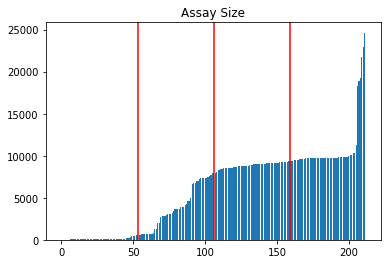

In [51]:
plt.bar(np.arange(len(sorted_assay_sizes)), [i[1] for i in sorted_assay_sizes])
plt.axvline(x=53, color='red')
plt.axvline(x=53*2, color='red')
plt.axvline(x=53*3, color='red')
plt.title('Assay Size')
 
plt.show()

### 2.1 Generate Fingerprint features per assay

In [21]:
# Convert the inchi list to a fp list
featurizer = dc.feat.CircularFingerprint(size=1024)
output_fps = [featurizer._featurize(Chem.inchi.MolFromInchi(str(i))).ToBitString()
              for i in output_inchi]
output_fps = np.array(output_fps)

In [30]:
fp_features = []

for c in range(output_matrix.shape[1]):
    fp_features.append(output_fps[output_matrix[:, c] != -1])
    
fp_features = np.array(fp_features)

In [41]:
# Create csv files. Each assay has one csv file.

for c in range(len(fp_features)):
    cur_dict = {
        # 'index': list(range(1, len(fp_features[c]) + 1)),
        'index': list(range(0, len(fp_features[c]))),
        'feature': fp_features[c].tolist()
    }
    cur_df = pd.DataFrame(cur_dict)
    cur_df.to_csv("./temp/fp_csvs/assay_{}.csv".format(c), index=False)

In [42]:
for c in range(len(fp_features)):
    print(len(fp_features[c]), c)

(3914, 0)
(695, 1)
(9691, 2)
(32, 3)
(56, 4)
(683, 5)
(2864, 6)
(4567, 7)
(795, 8)
(8662, 9)
(31, 10)
(61, 11)
(60, 12)
(1261, 13)
(9176, 14)
(18330, 15)
(9414, 16)
(30, 17)
(8784, 18)
(4136, 19)
(3645, 20)
(658, 21)
(62, 22)
(24626, 23)
(8949, 24)
(8409, 25)
(8355, 26)
(9026, 27)
(8358, 28)
(9692, 29)
(68, 30)
(10031, 31)
(8360, 32)
(8780, 33)
(58, 34)
(519, 35)
(9440, 36)
(9700, 37)
(7982, 38)
(2659, 39)
(9721, 40)
(9772, 41)
(9772, 42)
(47, 43)
(7576, 44)
(480, 45)
(37, 46)
(3887, 47)
(7333, 48)
(9546, 49)
(7328, 50)
(9537, 51)
(8692, 52)
(9654, 53)
(7950, 54)
(8593, 55)
(3046, 56)
(23, 57)
(9708, 58)
(3170, 59)
(9156, 60)
(8525, 61)
(9053, 62)
(9306, 63)
(114, 64)
(61, 65)
(9147, 66)
(9762, 67)
(8986, 68)
(8567, 69)
(9777, 70)
(18866, 71)
(3446, 72)
(10013, 73)
(9868, 74)
(9740, 75)
(6636, 76)
(10096, 77)
(9184, 78)
(2924, 79)
(9874, 80)
(9243, 81)
(10282, 82)
(8959, 83)
(8832, 84)
(9739, 85)
(9302, 86)
(39, 87)
(9144, 88)
(9455, 89)
(9726, 90)
(4253, 91)
(7370, 92)
(26, 93)
(8538,